[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb)

# Extending the Linear Representation Hypothesis with Sparse and Transcoder-Style Autoencoders for Hallucination Analysis

This notebook demonstrates an extension of the LRH using Sparse Autoencoders (SAEs) and Transcoder-Style Autoencoders by steering features in GPT-2 associated with hallucinations to demonstrate such steering can influence model outputs. The benchmark dataset used is the LAMBADA dataset, which contains cloze-style (i.e. 'fill-in-the-blank) problems, and our hooked/steered model is also further tested on the WritingPrompts and PIQA dataset to test for continuitu and generalisability of results. This notebook takes inspiration from the
[TransformerLens](https://github.com/TransformerLensOrg/TransformerLens/) library's [Exploratory Analysis demo Colab Notebook](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Exploratory_Analysis_Demo.ipynb).

**Note**: This notebook takes ~3 hours to run in its completion

## Setup

### Environment Setup

**Note**: Be sure to switch runtime to use a GPU for faster compute (e.g. T4 GPU).  If you have access to a high-RAM GPU (i.e. if you have Colab Pro), switching to use it will enable much better performance and allow for faster calculations

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
HIGH_RAM = True

if ram_gb < 20:
  HIGH_RAM = False
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install transformer_lens
!pip install circuitsvis
!pip install sae-lens
!pip install pandas
!pip uninstall -y numpy
!pip install numpy==1.26.4 # Newer numpy versions have dependency conflicts with pandas
# Install a faster Node version
!curl -fsSL https://deb.nodesource.com/setup_21.x | sudo -E bash -; sudo apt-get install -y nodejs  # noqa

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
2025-05-04 03:20:57 - Installing pre-requisites
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://deb.nodesource

### Imports

**Important Note**: Sometimes numpy fails to use the specified version (v1.26.4) after being imported, which causes an error when importing the rest of the libraries due to dependency conflicts.  If the following doesn't print '1.26.4', then restart session via: 'Runtime' --> 'Restart Session' to fix the issue.

In [ ]:
import numpy as np
print(np.__version__) # Should be 1.26.4
assert np.__version__ == '1.26.4'

1.26.4


The above block should have printed '1.26.4'.  If not, then restart session via 'Runtime' --> 'Restart Session'.  Else, continue.



In [ ]:
import torch
import scipy
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datasets import load_dataset
import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer
from sae_lens import SAE

### PyTorch Setup

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [ ]:
torch.set_grad_enabled(False)
print("Disabled automatic differentiation")

Disabled automatic differentiation


### Model and Dataset Import

In [ ]:
# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained("gpt2-small")
model.eval()

# Get the default device used
device: torch.device = utils.get_device()
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (h

In [ ]:
lambada = load_dataset("lambada", split="test")

# Inspect a sample problem
example_prompt, example_answer = lambada[0]['text'].rsplit(' ', 1)
print('Question: ' + example_prompt + '\n')
print('Answer: ' + example_answer)

Generating train split:   0%|          | 0/2662 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5153 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4869 [00:00<?, ? examples/s]

Question: in my palm is a clear stone , and inside it is a small ivory statuette . a guardian angel . `` figured if you 're going to be out at night getting hit by cars , you might as well have some backup . '' i look at him , feeling stunned . like this is some sort of sign . but as i stare at harlin , his mouth curved in a confident grin , i do n't care about

Answer: signs


We verify that our model can 'do' a task from this (LAMBADA) dataset (note that not all tasks may pass; we just want to verify that the model can do at least one of the tasks):

In [ ]:
example_prompt, example_answer = lambada[8]['text'].rsplit(' ', 1)
utils.test_prompt(example_prompt, example_answer, model, print_details=True, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '``', ' why', ' ?', " ''", ' ``', ' i', ' would', ' have', ' thought', ' you', " '", 'd', ' find', ' him', ' rather', ' dry', ' ,', " ''", ' she', ' said', ' .', ' ``', ' i', ' do', ' n', "'t", ' know', ' about', ' that', ' ,', " ''", ' said', ' g', 'ab', 'riel', ' .', ' ``', ' he', ' was', ' a', ' great', ' crafts', 'man', ' ,', " ''", ' said', ' he', 'ather', ' .', ' ``', ' that', ' he', ' was', ' ,', " ''", ' said', ' fl', 'an', 'nery', ' .', ' ``', ' and', ' polish', ' ,', ' to', ' boot', ' ,', " ''", ' said']
Tokenized answer: [' g', 'ab', 'riel']


Performance on answer token:
Rank: 0        Logit: 12.41 Prob:  6.08% Token: | g|

Top 0th token. Logit: 12.41 Prob:  6.08% Token: | g|
Top 1th token. Logit: 12.26 Prob:  5.24% Token: | he|
Top 2th token. Logit: 11.55 Prob:  2.57% Token: | j|
Top 3th token. Logit: 11.44 Prob:  2.31% Token: | m|
Top 4th token. Logit: 11.37 Prob:  2.16% Token: | l|
Top 5th token. Logit: 11.22 Prob:  1.86% Token: | the|
Top 6th token. Logit: 11.17 Prob:  1.77% Token: | she|
Top 7th token. Logit: 11.07 Prob:  1.60% Token: | b|
Top 8th token. Logit: 11.04 Prob:  1.55% Token: | d|
Top 9th token. Logit: 11.00 Prob:  1.50% Token: | t|


Performance on answer token:
Rank: 0        Logit: 20.36 Prob: 89.14% Token: |ab|

Top 0th token. Logit: 20.36 Prob: 89.14% Token: |ab|
Top 1th token. Logit: 15.36 Prob:  0.60% Token: |abby|
Top 2th token. Logit: 14.62 Prob:  0.29% Token: |az|
Top 3th token. Logit: 14.30 Prob:  0.21% Token: |ordon|
Top 4th token. Logit: 14.19 Prob:  0.19% Token: |ib|
Top 5th token. Logit: 14.15 Prob:  0.18% Token: |im|
Top 6th token. Logit: 14.10 Prob:  0.17% Token: |har|
Top 7th token. Logit: 14.00 Prob:  0.15% Token: |abe|
Top 8th token. Logit: 13.89 Prob:  0.14% Token: |abb|
Top 9th token. Logit: 13.86 Prob:  0.13% Token: |ag|


Performance on answer token:
Rank: 0        Logit: 21.65 Prob: 99.19% Token: |riel|

Top 0th token. Logit: 21.65 Prob: 99.19% Token: |riel|
Top 1th token. Logit: 14.42 Prob:  0.07% Token: |ri|
Top 2th token. Logit: 14.08 Prob:  0.05% Token: |ry|
Top 3th token. Logit: 13.78 Prob:  0.04% Token: |rie|
Top 4th token. Logit: 13.73 Prob:  0.04% Token: |rin|
Top 5th token. Logit: 13.61 Prob:  0.03% Token: |rier|
Top 6th token. Logit: 13.60 Prob:  0.03% Token: |rian|
Top 7th token. Logit: 13.31 Prob:  0.02% Token: |ric|
Top 8th token. Logit: 13.03 Prob:  0.02% Token: |rius|
Top 9th token. Logit: 12.98 Prob:  0.02% Token: |ril|


Ranks of the answer tokens: [(' g', 0), ('ab', 0), ('riel', 0)]

## Model Accuracy Calculation

Here, we take in the model's output token rankings and consider an answer correct iff token_rank=0 for all output/answer tokens.  As the LAMBADA dataset has one-word (though potentially multi-token) answers, we don't consider partial credit.

In [ ]:
# Note: Code from function test_prompt() in the
# [TransformerLens Library](https://github.com/TransformerLensOrg/TransformerLens/blob/main/transformer_lens/utils.py)
def get_out_tokens(prompt, answer, model):

  answers = [answer] if isinstance(answer, str) else answer
  n_answers = len(answers)
  using_multiple_answers = n_answers > 1

  answers = [answer if answer.startswith(" ") else " " + answer for answer in answers]

  # GPT-2 often treats the first token weirdly, so lets give it a resting position
  prompt_tokens = model.to_tokens(prompt, prepend_bos=True)
  answer_tokens = model.to_tokens(answers, prepend_bos=False)

  # If we have multiple answers, we're only allowed a single token generation
  if using_multiple_answers:
    answer_tokens = answer_tokens[:, :1]

  # Deal with case where answers is a list of strings
  prompt_tokens = prompt_tokens.repeat(answer_tokens.shape[0], 1)
  tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)

  prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=True)
  answer_str_tokens_list = [model.to_str_tokens(answer, prepend_bos=False) for answer in answers]

  prompt_length = len(prompt_str_tokens)
  answer_length = 1 if using_multiple_answers else len(answer_str_tokens_list[0])

  logits = model(tokens)
  probs = logits.softmax(dim=-1)
  answer_ranks = []

  for index in range(prompt_length, prompt_length + answer_length):
    # Get answer tokens for this sequence position
    answer_tokens = tokens[:, index]
    answer_str_tokens = [a[index - prompt_length] for a in answer_str_tokens_list]

    # Offset by 1 because models predict the NEXT token
    token_probs = probs[:, index - 1]
    sorted_token_probs, sorted_token_positions = token_probs.sort(descending=True)
    answer_token_ranks = sorted_token_positions.argsort(-1)[
      range(n_answers), answer_tokens.cpu()
    ].tolist()
    answer_ranks.append(
      [
        (answer_str_token, answer_token_rank)
          for answer_str_token, answer_token_rank in zip(
            answer_str_tokens, answer_token_ranks
          )
      ]
    )

  # If n_answers = 1 then unwrap answer ranks, so printed output matches original version of function
  if not using_multiple_answers:
    single_answer_ranks = [r[0] for r in answer_ranks]
    return single_answer_ranks
  else:
    return answer_ranks


def is_correct(out_tokens):
  for pair in out_tokens:
    if pair[1] != 0:
      return False, pair[1]
  return True, pair[1]


def is_prediction_correct(prompt, answer, model):
  out_tokens = get_out_tokens(prompt, answer, model)
  return is_correct(out_tokens)


def calc_accuracy(data, model, dataset_name='lambada'):
  correct = 0
  hallucinating_prompts = []
  correct_prompts = []
  for entry in tqdm(data, 'Calculating Accuracy'):

    if dataset_name == 'lambada':
      prompt, answer = entry['text'].rsplit(' ', 1)
    elif dataset_name == 'writingprompts':
      prompt, answer = entry['prompt'], entry['answer']
    elif dataset_name == 'piqa':
      prompt, answer = entry['prompt'], entry['answer']
    else:
      raise NotImplementedError

    pred_corr, token_rank = is_prediction_correct(prompt, answer, model)
    if pred_corr:
      correct += 1
      correct_prompts.append((prompt, token_rank))
    else:
      hallucinating_prompts.append((prompt, token_rank))
  return correct / len(data), hallucinating_prompts, correct_prompts

In [ ]:
gpt2_accuracy, hallucinations, correctly_answered = calc_accuracy(lambada, model)
print('\n' + 'Accuracy: ' + str(gpt2_accuracy))

Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]


Accuracy: 0.2699398408693965


In [ ]:
# Sort the hallucinating prompts in order of worst performing prediction
hallucinations.sort(key=lambda x: -1 * x[1])
hallucinating_prompts = [prompt for prompt, _ in hallucinations]

In [ ]:
[(prompts, ranks) for prompts, ranks in hallucinations[:20]]

[("` there was an unregistered flight detected on radio by both the indonesian and australian air forces around the time the tip-off predicted , but the plane veered off towards borneo where it somewhat skillfully dropped below radar . so , if we want to find out what pei 's been up to , we 'll have to go ask her ourselves . ' ` is that what you have in mind for me ? ' ` not exactly . i have a team ready to go to",
  31153),
 ("the moonlight also fell on myka 's purse , and the blue of the envelope sticking out of it . myka carefully slid out from under spike 's arm , took the two steps across the room , fetched the letter , opened it , moved to the moonlight , and started to read . jillian 's voice came to her across the divide . i hope that while you 're reading this , myka , you 're with",
  19571),
 ("it tasted delicious , the secret smiles drew and i shared as we were surrounded by dozens of strangers making my head light and my heart sing . after the party , we officially went to

In [ ]:
correct_prompts = [prompt for prompt, _ in correctly_answered]

We now have GPT-2's accuracy on the LAMBADA dataset as well as the prompts on which it hallucinated!

## SAEs

### SAE Feature Extraction

In [ ]:
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

hook_point = "blocks.8.hook_resid_post"
# hook_point = "blocks.8.hook_attn_out"

# Load SAE and model
sae, cfg_dict, sparsity = SAE.from_pretrained(
  release="gpt2-small-resid-post-v5-32k",
  # release="gpt2-small-attn-out-v5-32k",
  sae_id=hook_point,
  device=device
)
sae.hook_point = hook_point

sae.to(device)

Device: cuda


cfg.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/131k [00:00<?, ?B/s]

SAE(
  (activation_fn): TopK(
    (postact_fn): ReLU()
  )
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

We now hook the SAE into the model and run on the prompts that caused the original GPT-2 model to fail/hallucinate/predict incorrectly. This will yield the top features that correspond to hallucinations in this (LAMBADA) dataset, i.e. for cloze-style/fill-in-the-blank-style prompts.

In [ ]:
import gc

all_sae_features = []

#  def sae_hook(activations, hook):
#    sae_features = sae.encode(activations)
#    return sae.decode(sae_features)
#
#  model.add_hook(hook_point, sae_hook)

subset_frac = 0.05

# Use a subset of worst ~05% performing prompts
batch_size = 4
num_prompts_to_analyse = int(subset_frac * len(hallucinating_prompts)) // batch_size * batch_size

print(f"Analysing {num_prompts_to_analyse} prompts...")

top_hallucinating_prompts = hallucinating_prompts[:num_prompts_to_analyse]

# Run model and get activations
with torch.no_grad():
  max_seq_len = 0
  for i in tqdm(range(0, num_prompts_to_analyse, batch_size), 'Retrieving Activations'):
    batch_prompts = top_hallucinating_prompts[i : i + batch_size]

    _, cache = model.run_with_cache(batch_prompts)
    x_mid = cache[hook_point]  # [batch, seq, d_model]

    sae_features = sae.encode(x_mid)  # [batch, seq, d_sae]
    max_seq_len = max(max_seq_len, sae_features.shape[1])

    if HIGH_RAM:
      all_sae_features.append(sae_features.cpu())
    else:
      all_sae_features.append(sae_features)

    # Prevent OutOfMemoryError
    del cache
    del x_mid
    del sae_features
    torch.cuda.empty_cache()
    gc.collect()

Analysing 188 prompts...


Retrieving Activations:   0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
# Pad tensors to the maximum sequence length before concatenation
sae_features_list = []
for sae_feature_batch in tqdm(all_sae_features, 'Padding Tensors'):
  padding_shape = (0, 0, 0, max_seq_len - sae_feature_batch.shape[1])
  padded_batch = torch.nn.functional.pad(sae_feature_batch, padding_shape)
  sae_features_list.append(padded_batch)

  del sae_feature_batch
  del padding_shape
  del padded_batch
  torch.cuda.empty_cache()
  gc.collect()

if HIGH_RAM:
  sae_features = torch.cat(sae_features_list, dim=0).to(device)
else:
  sae_features = torch.cat(sae_features_list, dim=0)

del sae_features_list
del all_sae_features
torch.cuda.empty_cache()
gc.collect()

Padding Tensors:   0%|          | 0/47 [00:00<?, ?it/s]

0

In [ ]:
hallucinations_sae_features = sae_features
del sae_features

In [ ]:
all_sae_features = []

#  def sae_hook(activations, hook):
#    sae_features = sae.encode(activations)
#    return sae.decode(sae_features)
#
#  model.add_hook(hook_point, sae_hook)

subset_frac = 0.10

# Use a subset of ~10% of correct prompts
batch_size = 4
num_prompts_to_analyse = int(subset_frac * len(correct_prompts)) // batch_size * batch_size

print(f"Analysing {num_prompts_to_analyse} prompts...")

top_correct_prompts = correct_prompts[:num_prompts_to_analyse]

# Run model and get activations
with torch.no_grad():
  max_seq_len = 0
  for i in tqdm(range(0, num_prompts_to_analyse, batch_size), 'Retrieving Activations'):
    batch_prompts = top_correct_prompts[i : i + batch_size]

    _, cache = model.run_with_cache(batch_prompts)
    x_mid = cache[hook_point]  # [batch, seq, d_model]

    sae_features = sae.encode(x_mid)  # [batch, seq, d_sae]
    max_seq_len = max(max_seq_len, sae_features.shape[1])

    if HIGH_RAM:
      all_sae_features.append(sae_features.cpu())
    else:
      all_sae_features.append(sae_features)

    # Prevent OutOfMemoryError
    del cache
    del x_mid
    del sae_features
    torch.cuda.empty_cache()
    gc.collect()

Analysing 136 prompts...


Retrieving Activations:   0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
# Pad tensors to the maximum sequence length before concatenation
sae_features_list = []
for sae_feature_batch in tqdm(all_sae_features, 'Padding Tensors'):
  padding_shape = (0, 0, 0, max_seq_len - sae_feature_batch.shape[1])
  padded_batch = torch.nn.functional.pad(sae_feature_batch, padding_shape)
  sae_features_list.append(padded_batch)

  del sae_feature_batch
  del padding_shape
  del padded_batch
  torch.cuda.empty_cache()
  gc.collect()

if HIGH_RAM:
  sae_features = torch.cat(sae_features_list, dim=0).to(device)
else:
  sae_features = torch.cat(sae_features_list, dim=0)

del sae_features_list
del all_sae_features
torch.cuda.empty_cache()
gc.collect()

Padding Tensors:   0%|          | 0/34 [00:00<?, ?it/s]

0

In [ ]:
correct_sae_features = sae_features
del sae_features

We've now have the activations for each feature on (1) the hallucinating prompts, and (2) the correct prompts

### Feature Ranking

We now test 3 feature ranking approaches based on activations:

**(1)** A standard activation frequency and mean activation score weighted average approach

**(2)** A contrastive hallucination-related activations - correct-response-related activations approach (to remove features always prominent, e.g. punctuation-related features, from the top hallucination-causing features)

**(3)** A bayesian approach ranking features based on P[hallucinating | feature] + mean activations

The best feature ranking approach is the one which yields the greatest linear decrease in steering accuracy when the top extracted features are steered below.

In [ ]:
def rank_features(activations, top_k=10):

  # Compute metrics across batch and sequence dimensions
  chunk_size = 100
  num_features = activations.shape[-1]
  mean_acts = torch.zeros(num_features, device=activations.device)
  firing_rates = torch.zeros(num_features, device=activations.device)

  for i in range(0, activations.shape[0], chunk_size):
    chunk = activations[i:i + chunk_size]
    last_token_acts = chunk[:, -1, :] # Only use final token

    mean_acts += last_token_acts.mean(dim=0) * chunk.shape[0]
    firing_rates += (last_token_acts > 0).float().mean(dim=0) * chunk.shape[0]  # Weighted average

  mean_acts /= activations.shape[0]  # Normalize
  firing_rates /= activations.shape[0]  # Normalize

  # Combined score
  scores = 0.7*mean_acts + 0.3*firing_rates # [num_features]

  # Get top indices
  return torch.topk(scores, k=top_k).indices.cpu().numpy()  # [top_k]

In [ ]:
def rank_contrastive_features(halluc_acts, correct_acts, top_k=10):

    h = halluc_acts.reshape(-1, halluc_acts.shape[-1])
    c = correct_acts.reshape(-1, correct_acts.shape[-1])

    # h = halluc_acts[:, -1, :]
    # c = correct_acts[:, -1, :]

    # Compute mean activations per feature
    mu_h = h.mean(dim=0)  # [n_features]
    mu_c = c.mean(dim=0)  # [n_features]

    # Contrastive score: hallucination-specific activation
    contrast_score = mu_h - mu_c

    # Top-k by contrast score
    top_indices = torch.topk(contrast_score, k=top_k).indices.cpu().numpy()

    return top_indices

In [ ]:
def rank_features_bayes(activations, hallucinating_mask, top_k=10):

    # Flatten batch and sequence dimensions
    flat_acts = activations.reshape(-1, activations.shape[-1])
    flat_mask = hallucinating_mask.reshape(-1)

    # Convert PyTorch tensor to NumPy array
    flat_acts_np = flat_acts.cpu().numpy()
    flat_mask_np = flat_mask.cpu().numpy()

    # Calculate base probabilities
    p_halucinating = np.mean(flat_mask_np) + 1e-8
    p_feature_all = np.mean(flat_acts_np > 0, axis=0) + 1e-8  # P(feature)
    p_feature_hallu = np.mean(flat_acts_np[flat_mask] > 0, axis=0) + 1e-8  # P(feature|hallucinating)

    # Compute Bayesian score
    bayes_ratio = p_feature_hallu / p_feature_all  # Proportional to P(hallucinating|feature)
    mean_acts = np.mean(flat_acts_np, axis=0)  # Regularization term

    # Combined ranking: primary=ratio, secondary=mean activations
    combined_scores = bayes_ratio * p_halucinating + 0.1 * (mean_acts / np.max(mean_acts))  # 10% weight to activation magnitude

    # Get top indices
    return np.argsort(-combined_scores)[:top_k]

In [ ]:
top_k = 20

In [ ]:
top_feature_indices_standard = rank_features(hallucinations_sae_features, top_k)
print('Top Features:', top_feature_indices_standard)

Top Features: [15799 28729 22470  3487  4472 27644  3874 32200 11843 13590 27801  6341
 25402 25592 25795 13213  2760  9368  7181 22320]


In [ ]:
top_feature_indices_contrastive = rank_contrastive_features(hallucinations_sae_features, correct_sae_features, top_k)
print('Top Features:', top_feature_indices_contrastive)

Top Features: [ 4231 16569  2971 24292  3733  6346 23203  9951  5205 24232 13786 16586
  1312 25104 29836 23314 25246 17401  3423 14647]


In [ ]:
hallucinations_mask = torch.tensor([1 if prompt in hallucinating_prompts else 0 for prompt in lambada['text']])
top_feature_indices_bayesian = rank_features_bayes(hallucinations_sae_features, hallucinations_mask, top_k)
print('Top Features:', top_feature_indices_bayesian)

Top Features: [28729 13749 32366  5132 25906 22470  4231 10669 26466 15799  8786  3426
  4472  6341 18039  3874 19449  6971 26195 32200]


### Feature Interpretation

In [ ]:
from transformers import AutoTokenizer

def process_lambada(top_features, dataset, model, sae, feature_k=0, max_examples=5, using_lambada=True):
  """Analyze and visualize top features across LAMBADA examples"""
  device = model.cfg.device
  tokenizer = model.tokenizer

  # Analyze each example
  for idx in range(min(len(dataset), max_examples)):

    if using_lambada:
      text = dataset[idx]['text']
      prompt = ' '.join(text.split()[:-1])
      answer = text.split()[-1]
    else:
      prompt = dataset[idx]

    # Tokenize and process
    tokens = tokenizer.encode(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
      _, cache = model.run_with_cache(tokens)
      hidden = cache[sae.hook_point]
      sae_activations = sae.encode(hidden)[0]  # [seq_len, d_sae]

    # Get token strings with special characters handled
    token_strs = tokenizer.batch_decode(tokens[0], clean_up_tokenization_spaces=False)

    # Visualize top features for this example
    print(f"\nExample {idx+1}: ")

    feat_idx = top_features[feature_k]  # Show top k features

    feature_acts = sae_activations[:, feat_idx]

    # Highlight activation in context
    colored_tokens = []
    for i, (token, act) in enumerate(zip(token_strs, feature_acts)):
      intensity = min(int(act.item() * 10), 255)
      color_code = f"\033[38;2;{intensity};0;0m"
      reset_code = "\033[0m"
      colored_tokens.append(f"{color_code}[{token}]{reset_code}")


    print(f"Feature {feat_idx} (max act: {feature_acts.max():.2f}):")
    print(f"  - Prompt: '{prompt}'")
    if using_lambada:
      print(f"  - Answer: '{answer}'")
    print(" ".join(colored_tokens) + "\n")


Standard Feature Ranking's Top Feature Visualisation:

In [ ]:
for idx in range(top_k):
  process_lambada(
    top_features=top_feature_indices_standard,
    dataset=hallucinating_prompts,
    model=model,
    sae=sae,
    feature_k=idx,
    max_examples=1,
    using_lambada=False
  )


Example 1: 
Feature 15799 (max act: 0.00):
  - Prompt: '` there was an unregistered flight detected on radio by both the indonesian and australian air forces around the time the tip-off predicted , but the plane veered off towards borneo where it somewhat skillfully dropped below radar . so , if we want to find out what pei 's been up to , we 'll have to go ask her ourselves . ' ` is that what you have in mind for me ? ' ` not exactly . i have a team ready to go to'
[`] [ there] [ was] [ an] [ un] [registered] [ flight] [ detected] [ on] [ radio] [ by] [ both] [ the] [ ind] [ones] [ian] [ and] [ aust] [ral] [ian] [ air] [ forces] [ around] [ the] [ time] [ the] [ tip] [-] [off] [ predicted] [ ,] [ but] [ the] [ plane] [ ve] [ered] [ off] [ towards] [ borne] [o] [ where] [ it] [ somewhat] [ skill] [fully] [ dropped] [ below] [ radar] [ .] [ so] [ ,] [ if] [ we] [ want] [ to] [ find] [ out] [ what] [ pe] [i] [ '] [s] [ been] [ up] [ to] [ ,] [ we] [ '] [ll] [ have] [ to] [ go] [ ask] [ 

Contrastive Feature Ranking's Top Feature Visualisation:

In [ ]:
for idx in range(top_k):
  process_lambada(
    top_features=top_feature_indices_contrastive,
    dataset=hallucinating_prompts,
    model=model,
    sae=sae,
    feature_k=idx,
    max_examples=1,
    using_lambada=False
  )


Example 1: 
Feature 4231 (max act: 0.70):
  - Prompt: '` there was an unregistered flight detected on radio by both the indonesian and australian air forces around the time the tip-off predicted , but the plane veered off towards borneo where it somewhat skillfully dropped below radar . so , if we want to find out what pei 's been up to , we 'll have to go ask her ourselves . ' ` is that what you have in mind for me ? ' ` not exactly . i have a team ready to go to'
[`] [ there] [ was] [ an] [ un] [registered] [ flight] [ detected] [ on] [ radio] [ by] [ both] [ the] [ ind] [ones] [ian] [ and] [ aust] [ral] [ian] [ air] [ forces] [ around] [ the] [ time] [ the] [ tip] [-] [off] [ predicted] [ ,] [ but] [ the] [ plane] [ ve] [ered] [ off] [ towards] [ borne] [o] [ where] [ it] [ somewhat] [ skill] [fully] [ dropped] [ below] [ radar] [ .] [ so] [ ,] [ if] [ we] [ want] [ to] [ find] [ out] [ what] [ pe] [i] [ '] [s] [ been] [ up] [ to] [ ,] [ we] [ '] [ll] [ have] [ to] [ go] [ ask] [ h

Bayesian Feature Ranking's Top Feature Visualisation:

In [ ]:
for idx in range(top_k):
  process_lambada(
    top_features=top_feature_indices_bayesian,
    dataset=hallucinating_prompts,
    model=model,
    sae=sae,
    feature_k=idx,
    max_examples=1,
    using_lambada=False
  )


Example 1: 
Feature 28729 (max act: 4.43):
  - Prompt: '` there was an unregistered flight detected on radio by both the indonesian and australian air forces around the time the tip-off predicted , but the plane veered off towards borneo where it somewhat skillfully dropped below radar . so , if we want to find out what pei 's been up to , we 'll have to go ask her ourselves . ' ` is that what you have in mind for me ? ' ` not exactly . i have a team ready to go to'
[`] [ there] [ was] [ an] [ un] [registered] [ flight] [ detected] [ on] [ radio] [ by] [ both] [ the] [ ind] [ones] [ian] [ and] [ aust] [ral] [ian] [ air] [ forces] [ around] [ the] [ time] [ the] [ tip] [-] [off] [ predicted] [ ,] [ but] [ the] [ plane] [ ve] [ered] [ off] [ towards] [ borne] [o] [ where] [ it] [ somewhat] [ skill] [fully] [ dropped] [ below] [ radar] [ .] [ so] [ ,] [ if] [ we] [ want] [ to] [ find] [ out] [ what] [ pe] [i] [ '] [s] [ been] [ up] [ to] [ ,] [ we] [ '] [ll] [ have] [ to] [ go] [ ask] [ 

**Remark**: These feature/activation visualisations on prompts indicate no dominant words/patterns in activation spikes! In fact, most prompts exhibit very low max activations across all tested features! This may be because hallucination-causing features are inherently structural in nature, and thus don't have any semantic meaning.  This would explain why no specific words/punctuation/sentence structures like adjectives, adverbs, etc. are highlighted in the above visual representation, as these 'hallucination features' capture underlying structures and not semantic representations/relationships!

**Note**: Attempting to interpret/qualitatively analyse the 'meaning' of these features is explored in the Transcoder_Circuit_Visualisation.ipynb

### Feature Steering

In [ ]:
def setup_steering(feature_idx, factor):
    """Steer multiple SAE features with scaled vector"""

    with torch.no_grad():
        steering_vec = sae.W_dec[feature_idx].clone()  # [d_model]

    def steering_hook(activations, hook):
        if factor == 0.0:
            return activations
        steering_vec_local = steering_vec.to(activations.device)
        steered = activations.clone()
        steered[:, -2, :] += steering_vec_local * factor  # steer only final token
        return steered

    return steering_hook

In [ ]:
mag_factor = 10
features_steered = 10

Feature Steering using the Standard Feature Ranking Approach:

In [ ]:
hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in top_feature_indices_standard[:features_steered]]

with model.hooks(hooks):
  hooked_accuracy, hallucinations, correctly_answered = calc_accuracy(lambada, model)
  print('\n' + 'Accuracy: ' + str(hooked_accuracy))

Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]


Accuracy: 0.2452940034931108


Feature Steering using the Contrastive Feature Ranking Approach:

In [ ]:
hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in top_feature_indices_contrastive[:features_steered]]

with model.hooks(hooks):
  hooked_accuracy, hallucinations, correctly_answered = calc_accuracy(lambada, model)
  print('\n' + 'Accuracy: ' + str(hooked_accuracy))

Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]


Accuracy: 0.24160683097224916


Feature Steering using the Bayesian Feature Ranking Approach:

In [ ]:
hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in top_feature_indices_bayesian[:features_steered]]

with model.hooks(hooks):
  hooked_accuracy, hallucinations, correctly_answered = calc_accuracy(lambada, model)
  print('\n' + 'Accuracy: ' + str(hooked_accuracy))

Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]


Accuracy: 0.25460896565107705


From these results, the contrastive feature ranking approach is the clear winner (Feel free to vary mag_factor to other values — e.g. mag_factor = 5, 15, 20, etc — or the number of features steered — e.g. features_steered = 1, 5, 10, 20, etc — to compare performance across other conditions)! We will thus use the contrastive feature ranking when feature steering in the future.

In [ ]:
top_feature_indices = top_feature_indices_contrastive
print(top_feature_indices)

[ 4231 16569  2971 24292  3733  6346 23203  9951  5205 24232 13786 16586
  1312 25104 29836 23314 25246 17401  3423 14647]


**Note**: Paste the above printed top features into the top (indicated) block of Transcoder_Circuit_Visualisation.ipynb to visualise, interpret, and qualitatively analyse the 'meaning' of these features across model layers.

## Transcoders

### Training Transcoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
torch.set_grad_enabled(True)
print("Enabled automatic differentiation")

Enabled automatic differentiation


In [ ]:
d_sae = sae.W_dec.shape[0]
d_trans = 1
subset_frac = 0.05

In [ ]:
# Define Transcoder Module
class Transcoder(nn.Module):
  def __init__(self, d_sae, d_trans):
    super().__init__()
    self.T = nn.Linear(d_sae, d_trans, bias=False)  # T maps sparse SAE space to hallucination space

  def forward(self, sae_activations):
    return self.T(sae_activations)

In [ ]:
def extract_sae_feats_from_hallucinations(model, sae, hallucinations, hook_point):
  sae_feats_list = []
  labels = []

  for prompt, token_rank in tqdm(hallucinations, desc="Extracting SAE features"):
    tokens = model.to_tokens(prompt, prepend_bos=True)

    with torch.no_grad():
      _, cache = model.run_with_cache(tokens)
      resid = cache[hook_point]             # [1, seq, d_model]
      sae_act = sae.encode(resid)[0, -2, :] # [d_sae]

    sae_feats_list.append(sae_act.cpu())
    labels.append([token_rank])  # higher rank = more hallucinated

  sae_feats = torch.stack(sae_feats_list)  # [N, d_sae]
  hallucination_scores = torch.tensor(labels, dtype=torch.float32)  # [N, 1]

  return sae_feats, hallucination_scores

In [ ]:
sae_feats, halluc_scores = extract_sae_feats_from_hallucinations(
  model=model,
  sae=sae,
  hallucinations=hallucinations[:int(subset_frac * len(hallucinations))],
  hook_point=hook_point
)

Extracting SAE features:   0%|          | 0/192 [00:00<?, ?it/s]

In [ ]:
# Min-max normalise to avoid exploding gradients
halluc_scores = (halluc_scores - halluc_scores.min()) / (halluc_scores.max() - halluc_scores.min())

In [ ]:
def create_dataloader(sae_feats, halluc_scores, batch_size=64):
    dataset = TensorDataset(sae_feats, halluc_scores)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataloader = create_dataloader(sae_feats, halluc_scores)

In [ ]:
def train_transcoder(T, dataloader, n_epochs=10, lr=1e-3, l1_lambda=1e-4):
  opt = torch.optim.Adam(T.parameters(), lr=lr)

  for epoch in range(n_epochs):
    total_loss = 0
    for x, y in dataloader:
      opt.zero_grad()
      out = T(x)  # [B, d_trans]
      loss = F.mse_loss(out, y)

      # Encourage sparsity
      l1 = l1_lambda * T.T.weight.abs().sum()
      loss += l1

      loss.backward()
      opt.step()
      total_loss += loss.item()

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")
  return T

In [ ]:
from sklearn.model_selection import train_test_split

train_feats, val_feats, train_labels, val_labels = train_test_split(
    sae_feats, halluc_scores, test_size=0.2
)

T = Transcoder(d_sae=d_sae, d_trans=d_trans)
loader = create_dataloader(train_feats, train_labels)

T = train_transcoder(T, loader, n_epochs=50)

Epoch 1 | Loss: 0.0283
Epoch 2 | Loss: 0.0144
Epoch 3 | Loss: 0.0124
Epoch 4 | Loss: 0.0094
Epoch 5 | Loss: 0.0075
Epoch 6 | Loss: 0.0067
Epoch 7 | Loss: 0.0060
Epoch 8 | Loss: 0.0048
Epoch 9 | Loss: 0.0043
Epoch 10 | Loss: 0.0039
Epoch 11 | Loss: 0.0033
Epoch 12 | Loss: 0.0031
Epoch 13 | Loss: 0.0027
Epoch 14 | Loss: 0.0028
Epoch 15 | Loss: 0.0024
Epoch 16 | Loss: 0.0022
Epoch 17 | Loss: 0.0022
Epoch 18 | Loss: 0.0021
Epoch 19 | Loss: 0.0021
Epoch 20 | Loss: 0.0020
Epoch 21 | Loss: 0.0021
Epoch 22 | Loss: 0.0020
Epoch 23 | Loss: 0.0019
Epoch 24 | Loss: 0.0019
Epoch 25 | Loss: 0.0018
Epoch 26 | Loss: 0.0018
Epoch 27 | Loss: 0.0018
Epoch 28 | Loss: 0.0017
Epoch 29 | Loss: 0.0018
Epoch 30 | Loss: 0.0017
Epoch 31 | Loss: 0.0018
Epoch 32 | Loss: 0.0018
Epoch 33 | Loss: 0.0017
Epoch 34 | Loss: 0.0018
Epoch 35 | Loss: 0.0016
Epoch 36 | Loss: 0.0018
Epoch 37 | Loss: 0.0017
Epoch 38 | Loss: 0.0017
Epoch 39 | Loss: 0.0018
Epoch 40 | Loss: 0.0016
Epoch 41 | Loss: 0.0018
Epoch 42 | Loss: 0.0016
E

In [ ]:
with torch.no_grad():
    val_preds = T(val_feats)
    val_loss = F.mse_loss(val_preds, val_labels)
    print(f"Validation MSE: {val_loss.item():.4f}")

Validation MSE: 0.0581


### Interpreting with Transcoders

In [ ]:
torch.save(T.state_dict(), "transcoder_halluc.pth")
T_loaded = Transcoder(d_sae=T.T.in_features, d_trans=1)
T_loaded.load_state_dict(torch.load("transcoder_halluc.pth"))
T_loaded.eval()

Transcoder(
  (T): Linear(in_features=32768, out_features=1, bias=False)
)

In [ ]:
halluc_w = T_loaded.T.weight[0]
top_idx = torch.topk(halluc_w.abs(), k=top_k).indices
for f in top_idx:
    print(f"Feature {f:>5}  weight = {halluc_w[f]:+.4f}")

Feature  1594  weight = +0.0150
Feature  8388  weight = +0.0144
Feature 22550  weight = +0.0135
Feature 25791  weight = +0.0124
Feature 26039  weight = +0.0119
Feature 26150  weight = +0.0113
Feature  7383  weight = +0.0111
Feature 18267  weight = +0.0105
Feature 11656  weight = +0.0104
Feature 18347  weight = -0.0102
Feature  9951  weight = +0.0096
Feature 13254  weight = -0.0094
Feature 22372  weight = -0.0087
Feature  7556  weight = +0.0083
Feature 16457  weight = +0.0083
Feature 32543  weight = +0.0082
Feature 27779  weight = +0.0077
Feature 20786  weight = +0.0074
Feature 11807  weight = +0.0074
Feature 27960  weight = +0.0073


In [ ]:
sorted_indices = torch.argsort(halluc_w.abs(), descending=True)
for f in top_feature_indices:
  rank = (sorted_indices == f).nonzero(as_tuple=True)[0].item()
  print(f"Feature {f} has rank {rank}/{d_sae} in absolute weight magnitude.")

Feature 4231 has rank 146/32768 in absolute weight magnitude.
Feature 16569 has rank 30474/32768 in absolute weight magnitude.
Feature 2971 has rank 247/32768 in absolute weight magnitude.
Feature 24292 has rank 57/32768 in absolute weight magnitude.
Feature 3733 has rank 8682/32768 in absolute weight magnitude.
Feature 6346 has rank 25441/32768 in absolute weight magnitude.
Feature 23203 has rank 261/32768 in absolute weight magnitude.
Feature 9951 has rank 10/32768 in absolute weight magnitude.
Feature 5205 has rank 109/32768 in absolute weight magnitude.
Feature 24232 has rank 71/32768 in absolute weight magnitude.
Feature 13786 has rank 28114/32768 in absolute weight magnitude.
Feature 16586 has rank 30679/32768 in absolute weight magnitude.
Feature 1312 has rank 22279/32768 in absolute weight magnitude.
Feature 25104 has rank 15272/32768 in absolute weight magnitude.
Feature 29836 has rank 10062/32768 in absolute weight magnitude.
Feature 23314 has rank 1334/32768 in absolute weig

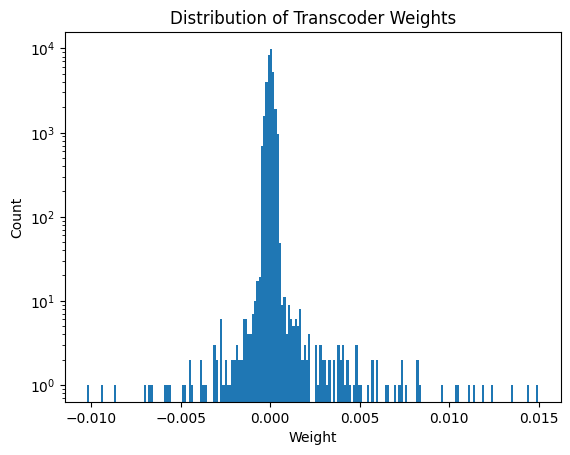

In [ ]:
plt.hist(halluc_w.detach().cpu(), bins=200, log=True)
plt.title("Distribution of Transcoder Weights")
plt.xlabel("Weight"); plt.ylabel("Count"); plt.show()

## Results

### Steering Accuracy vs Steering Coefficient Plots

#### Multi-Feature Steering

In [ ]:
mag_factors = [-5.0, -2.0, 0.0, 5.0, 10.0, 15.0, 20.0]
k_vals = [5, 10, 20]

We also collect accuracy values for steering a random selection of 10 features for use as a baseline/control comparison when plotting steering accuracy vs magnification factor for the top SAE-selected features across different numbers of features selected.

**Note**: This block of code is computationally intensive and takes ~20 minutes to run.

In [ ]:
import random
random.seed(100)

control_results = []
k = 10
random_features = random.sample(range(sae.W_dec.shape[0]), k)

print(f'Calculating for {k} Randomly Selected Features...')
for mag_factor in mag_factors:
  print(f'Mag Factor: {mag_factor}x')
  random_hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in random_features]
  with model.hooks(random_hooks):
    accuracy, _, _ = calc_accuracy(lambada, model)
    print(f'Accuracy: {accuracy}')
    control_results.append(accuracy)

Calculating for 10 Randomly Selected Features...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.26411798952066756
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2674170386182806
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2699398408693965
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.26974577915777215
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2679992237531535
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2621773724044246
Mag Factor: 20.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.24956336114884534


**Note**: The next block of code is *very* computationally intensive and will take ~60 minutes to run.

In [ ]:
# Plot model accuracy on LAMBADA vs magnification factors of top {5, 10, 20} hallucination-inducing features
results = []

for k_val in k_vals:
  accuracy_results = []
  print(f'Calculating for Top {k_val} Features...')
  for mag_factor in mag_factors:
    print(f'Mag Factor: {mag_factor}x')
    hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in top_feature_indices[:k_val]]
    with model.hooks(hooks):
      accuracy, _, _ = calc_accuracy(lambada, model)
      accuracy_results.append(accuracy)
      print(f'Accuracy: {accuracy}')
  results.append(accuracy_results)

Calculating for Top 5 Features...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.27149233456239086
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.27110421113914224
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2699398408693965
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2639239278090433
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.25247428682320977
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.23636716475839317
Mag Factor: 20.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.21152726567048322
Calculating for Top 10 Features...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2685814088880264
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.27013390258102077
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2699398408693965
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.26023675528818163
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.24160683097224916
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2062875994566272
Mag Factor: 20.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.15117407335532698
Calculating for Top 20 Features...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2612070638463031
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2691635940228993
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2699398408693965
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2555792742091985
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.21909567242383077
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.15408499902969144
Mag Factor: 20.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.08538715311469047


In [ ]:
# Compute the Confidence Interval for the accuracy metric of the steered model
def normal_ci(accuracies, n, ci=95):
  accuracies = np.array(accuracies)
  z = 1.96 if ci == 95 else scipy.stats.norm.ppf(1 - (1 - ci / 100) / 2)
  se = np.sqrt(accuracies * (1 - accuracies) / n)
  return accuracies - z * se, accuracies + z * se

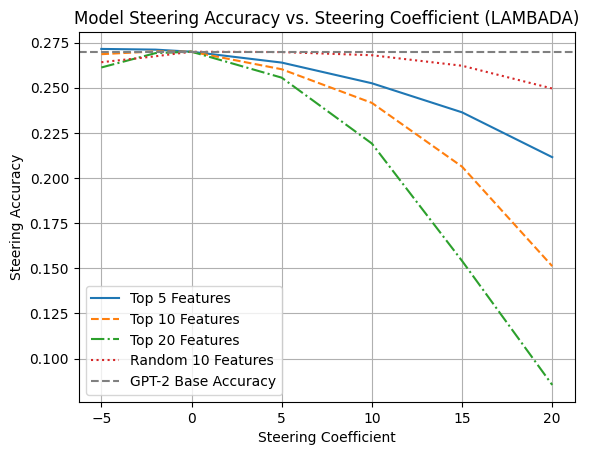

In [ ]:
# Plot Accuracy vs Steering Coefficient with 95% Confidence Bars
linestyles = ['-', '--', '-.']
for i in range(len(results)):
  l, u = normal_ci(results[i], num_prompts_to_analyse)
  err = np.array([np.array(results[i]) - l, u - np.array(results[i])])
  # plt.fill_between(mag_factors, l, u, alpha=0.2)
  plt.plot(mag_factors, results[i], linestyle=linestyles[i], label=f'Top {k_vals[i]} Features')

l, u = normal_ci(control_results, num_prompts_to_analyse)
control_err = np.array([np.array(control_results) - l, u - np.array(control_results)])
# plt.fill_between(mag_factors, l, u, alpha=0.2)
plt.plot(mag_factors, control_results, linestyle=':', label=f'Random {k} Features')

plt.axhline(y=gpt2_accuracy, color='gray', linestyle='--', label='GPT-2 Base Accuracy')
plt.xlabel('Steering Coefficient')
plt.ylabel('Steering Accuracy')
plt.title('Model Steering Accuracy vs. Steering Coefficient (LAMBADA)')
plt.grid(True)
plt.legend()
plt.show()

#### Single-Feature Steering

We now compare the effect of steering the top feature vs a random feature

**Note**: The next block is computationally intensive and will take ~20 minutes to run

In [ ]:
single_control_results = []
random_features = random.sample(range(sae.W_dec.shape[0]), 1)

print(f'Calculating for {1} Randomly Selected Feature...')
for mag_factor in mag_factors:
  print(f'Mag Factor: {mag_factor}x')
  random_hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in random_features]
  with model.hooks(random_hooks):
    accuracy, _, _ = calc_accuracy(lambada, model)
    print(f'Accuracy: {accuracy}')
    single_control_results.append(accuracy)

Calculating for 1 Randomly Selected Feature...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2699398408693965
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.27013390258102077
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2699398408693965
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2691635940228993
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2664467300601591
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.26567048321366193
Mag Factor: 20.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.26605860663691056


**Note**: The next block is computationally intensive and will take ~20 minutes to run

In [ ]:
# Plot model accuracy on LAMBADA vs Steering Coefficients of top hallucination-inducing feature
single_results = []

print(f'Calculating for Top {1} Features...')
for mag_factor in mag_factors:
  print(f'Mag Factor: {mag_factor}x')
  hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in top_feature_indices[:1]]
  with model.hooks(hooks):
    accuracy, _, _ = calc_accuracy(lambada, model)
    print(f'Accuracy: {accuracy}')
    single_results.append(accuracy)

Calculating for Top 1 Features...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.27226858140888804
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2718804579856394
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2699398408693965
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2672229769066563
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.26431205123229184
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.26062487871143025
Mag Factor: 20.0x


Calculating Accuracy:   0%|          | 0/5153 [00:00<?, ?it/s]

Accuracy: 0.2563555210556957


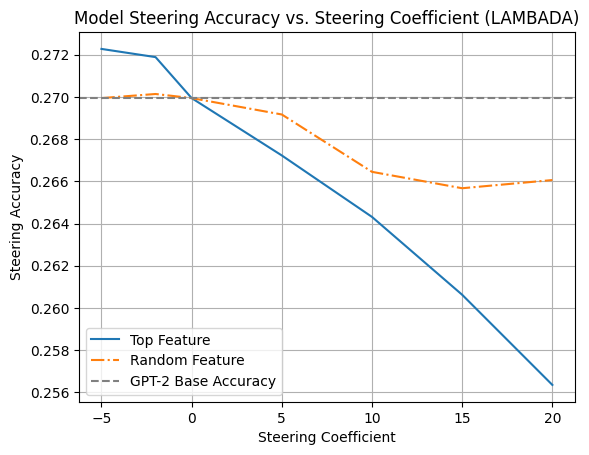

In [ ]:
# Plot Accuracy vs Steering Coefficients

l, u = normal_ci(single_results, num_prompts_to_analyse)
err = np.array([np.array(single_results) - l, u - np.array(single_results)])
plt.plot(mag_factors, single_results, linestyle='-', label=f'Top Feature')


l, u = normal_ci(single_control_results, num_prompts_to_analyse)
control_err = np.array([np.array(single_control_results) - l, u - np.array(single_control_results)])
plt.plot(mag_factors, single_control_results, linestyle='-.', label=f'Random Feature')

plt.axhline(y=gpt2_accuracy, color='gray', linestyle='--', label='GPT-2 Base Accuracy')
plt.xlabel('Steering Coefficient')
plt.ylabel('Steering Accuracy')
plt.title('Model Steering Accuracy vs. Steering Coefficient (LAMBADA)')
plt.grid(True)
plt.legend()
plt.show()

### Continuity of Hallucination-Causing Features to Other Datasets

We now compare the results of running our hooked/steered model steering features associated with hallucinations in the LAMBADA dataset on another cloze-style dataset to investigate whether these hallucination-causing features for LAMBADA also contribute to hallucinations in other datasets with similar prompts.

#### WritingPrompts

We use the WritingPrompts dataset, but filter it to ensure the prompts aren't too long for our model (gpt2-small, which has a context limit of 1024 tokens) to handle. We also slightly reformat the answer format to be cloze-style, as opposed to predicting the last sentence in its entirety.

In [ ]:
writing_prompts = load_dataset('euclaise/writingprompts', split='test')

Generating train split:   0%|          | 0/272600 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/15138 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15620 [00:00<?, ? examples/s]

We reformat the dataset's prompts to be cloze-style and under the token context limit:

In [ ]:
import string
from transformers import AutoTokenizer

def create_cloze_example(example):
  story = example['story']
  words = story.strip().split()
  if len(words) < 5:
    return None
  prompt = ' '.join(words[:-1])
  target = words[-1].strip(string.punctuation)
  return {'prompt': prompt, 'answer': target}

tokenizer = AutoTokenizer.from_pretrained("gpt2")

def is_under_token_limit(example, max_tokens=900):
  input_ids = tokenizer.encode(example['prompt'], add_special_tokens=False)
  return len(input_ids) <= max_tokens

processed_writprompt = writing_prompts.map(create_cloze_example)
processed_writprompt = processed_writprompt.filter(lambda x: x is not None)
writing_prompts = processed_writprompt.filter(is_under_token_limit)

Map:   0%|          | 0/15138 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15138 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15138 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1134 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
# Confirm dataset prompt and answer structure
print('Prompt: ' + writing_prompts[0]['prompt'])
print('Answer: ' + writing_prompts[0]['answer'])

Prompt: The wet marble floor pressed on his cheek like a thousand hands slapping his face frozen in time. Smattering piss of rain ignored his indignant mumblings. His eyes fluttered. Pins and needs ran from finger to shoulder as he pushed back against the floor, contorting his aching body into a cross legged position. Last night was bad. He gathered that. His routine dullness of though crept inwards from the edges of his mind toward the black mist that veiled his most recent memories. He struggled to recall whatever he could n't recall but only for a moment before he decided it probably was n't worth the effort. He glanced around the room for a few minutes before concluding that he probably did n't know where he was. His investigation was n't entirely fruitless, he discovered a mostly full bottle of vodka. It was cheap but would definitely get the job done. Taking a few swigs made it childishly easy to ignore that gigantic black cloud of fog blotting out whatever the hell he did before

For the sake of runtime, we limit the dataset to 1000 prompts, which is still representative of the full ~12000 prompt dataset by the Law of Large Numbers.  To run the model on the full dataset (or some other sized subset), change the value of dataset_size below

In [ ]:
dataset_size = 1000
writing_prompts = writing_prompts.select(range(dataset_size))

In [ ]:
writprompt_gpt2_accuracy, _, _ = calc_accuracy(writing_prompts, model, dataset_name='writingprompts')
print('\n' + 'Accuracy: ' + str(writprompt_gpt2_accuracy))

Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]


Accuracy: 0.251


In [ ]:
top_k = 20
mag_factor = 10

In [ ]:
hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in top_feature_indices[:top_k]]

with model.hooks(hooks):
  gpt2_accuracy, _, _ = calc_accuracy(writing_prompts, model, dataset_name='writingprompts')
  print('\n' + 'Accuracy: ' + str(gpt2_accuracy))

Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]


Accuracy: 0.214


We see a decrease in accuracy even in the WritingPrompts dataset by steering the features our SAE extracted that were associated with hallucinations in the LAMBADA dataset! To further demonstrate this, we again plot steering accuracy vs steering coefficient but for running the model on the WritingPrompts dataset.

In [ ]:
mag_factors = [-5.0, -2.0, 0.0, 5.0, 10.0, 15.0, 20.0]
k = 10

**Note**: The following block will take ~10 minutes to run

In [ ]:
import random
random.seed(100)

writprompt_control_results = []
random_features = random.sample(range(sae.W_dec.shape[0]), k)

print(f'Calculating for {k} Randomly Selected Feature...')
for mag_factor in mag_factors:
  print(f'Mag Factor: {mag_factor}x')
  random_hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in random_features]
  with model.hooks(random_hooks):
    accuracy, _, _ = calc_accuracy(writing_prompts, model, dataset_name='writingprompts')
    print(f'Accuracy: {accuracy}')
    writprompt_control_results.append(accuracy)

Calculating for 10 Randomly Selected Feature...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.247
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.248
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.251
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.248
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.25
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.247
Mag Factor: 20.0x


Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.228


**Note**: The following block will take ~10 minutes to run

In [ ]:
writprompt_results = []

print(f'Calculating for Top {k} Features...')
for mag_factor in mag_factors:
  print(f'Mag Factor: {mag_factor}x')
  hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in top_feature_indices[:k]]
  with model.hooks(hooks):
    accuracy, _, _ = calc_accuracy(writing_prompts, model, dataset_name='writingprompts')
    print(f'Accuracy: {accuracy}')
    writprompt_results.append(accuracy)

Calculating for Top 10 Features...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.247
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.247
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.251
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.246
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.238
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.217
Mag Factor: 20.0x


Calculating Accuracy:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy: 0.19


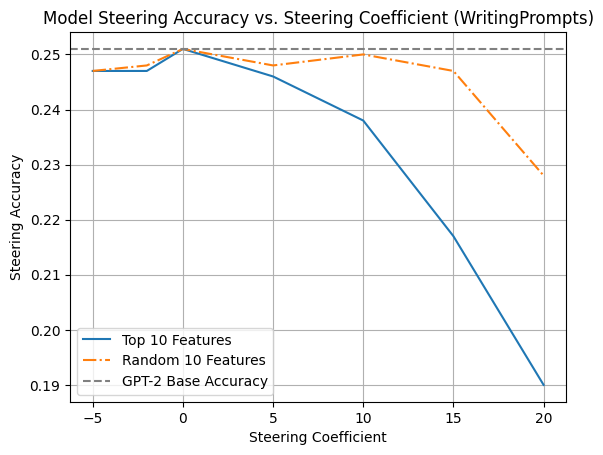

In [ ]:
# Plot Accuracy vs Steering Coefficient
l, u = normal_ci(writprompt_results, num_prompts_to_analyse)
err = np.array([np.array(writprompt_results) - l, u - np.array(writprompt_results)])
plt.plot(mag_factors, writprompt_results, linestyle='-', label=f'Top {k} Features')

l, u = normal_ci(writprompt_control_results, num_prompts_to_analyse)
control_err = np.array([np.array(writprompt_control_results) - l, u - np.array(writprompt_control_results)])
plt.plot(mag_factors, writprompt_control_results, linestyle='-.', label=f'Random {k} Features')

plt.axhline(y=writprompt_gpt2_accuracy, color='gray', linestyle='--', label='GPT-2 Base Accuracy')

plt.xlabel('Steering Coefficient')
plt.ylabel('Steering Accuracy')
plt.title('Model Steering Accuracy vs. Steering Coefficient (WritingPrompts)')
plt.grid(True)
plt.legend()
plt.show()

#### PIQA

We now look at a second additional dataset, though one which doesn't contain long-context narrative/story-like tasks (like LAMBADA and WritingPrompts) to determine if these hallucination features are truly generalisable: PIQA.  PIQA contains short-context physical commensense-grounded (as opposed to literary structure-grounded) tasks, e.g: 'To move a couch, it's best to ___'.  We massage the prompt/answer structure to be cloze-style to fit with the steering and accuracy calculation architecture developed in this notebook.

In [ ]:
piqa = load_dataset('piqa', split='test', trust_remote_code=True)

Generating train split:   0%|          | 0/16113 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3084 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1838 [00:00<?, ? examples/s]

We reformat the dataset's prompts to be cloze-style:

In [ ]:
import string

def create_piqa_cloze(example):
  goal = example["goal"].strip()
  label = int(example["label"])
  solution = example["sol1"] if label == 0 else example["sol2"]

  words = solution.strip().split()
  if len(words) == 0:
    return None

  prompt_addition = " ".join(words[:-1])
  answer = words[-1].strip(string.punctuation)

  full_prompt = goal + " " + prompt_addition

  return {
    "prompt": full_prompt,
    "answer": answer
  }

piqa_cloze = piqa.map(create_piqa_cloze)
piqa = piqa_cloze.filter(lambda x: x["prompt"] is not None and x["answer"] is not None and x["answer"].isalpha())

Map:   0%|          | 0/3084 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3084 [00:00<?, ? examples/s]

In [ ]:
# Confirm dataset prompt and answer structure
print('Prompt: ' + piqa[2]['prompt'])
print('Answer: ' + piqa[2]['answer'])

Prompt: What ingredients do I need to make a shortcrust for mini pies? To make pie crust, you will need flour, sugar, butter, and ice
Answer: water


In [ ]:
piqa_gpt2_accuracy, _, _ = calc_accuracy(piqa, model, dataset_name='piqa')
print('\n' + 'Accuracy: ' + str(piqa_gpt2_accuracy))

Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]


Accuracy: 0.30839594903626266


In [ ]:
top_k = 20
mag_factor = 10

In [ ]:
hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in top_feature_indices[:top_k]]

with model.hooks(hooks):
  gpt2_accuracy, _, _ = calc_accuracy(piqa, model, dataset_name='piqa')
  print('\n' + 'Accuracy: ' + str(gpt2_accuracy))

Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]


Accuracy: 0.26069911793531525


We see a decrease in accuracy even in the PIQA dataset by steering the features our SAE extracted that were associated with hallucinations in the LAMBADA dataset, which contains entirely different tasks than PIQA! To further demonstrate this, we again plot steering accuracy vs steering coefficient but for running the model on the PIQA dataset.

In [ ]:
mag_factors = [-5.0, -2.0, 0.0, 5.0, 10.0, 15.0, 20.0]
k = 10

**Note**: The following block will take ~10 minutes to run

In [ ]:
import random
random.seed(100)

piqa_control_results = []
random_features = random.sample(range(sae.W_dec.shape[0]), k)

print(f'Calculating for {k} Randomly Selected Feature...')
for mag_factor in mag_factors:
  print(f'Mag Factor: {mag_factor}x')
  random_hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in random_features]
  with model.hooks(random_hooks):
    accuracy, _, _ = calc_accuracy(piqa, model, dataset_name='piqa')
    print(f'Accuracy: {accuracy}')
    piqa_control_results.append(accuracy)

Calculating for 10 Randomly Selected Feature...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]

Accuracy: 0.3031688990525972
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]

Accuracy: 0.3100294021561581
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]

Accuracy: 0.30839594903626266
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]

Accuracy: 0.3077425677883045
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]

Accuracy: 0.3044756615485136
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]

Accuracy: 0.2914080365893499
Mag Factor: 20.0x


Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]

Accuracy: 0.270499836654688


**Note**: The following block will take ~10 minutes to run

In [ ]:
piqa_results = []

print(f'Calculating for Top {k} Features...')
for mag_factor in mag_factors:
  print(f'Mag Factor: {mag_factor}x')
  hooks = [(sae.hook_point, setup_steering(feature_idx = idx, factor = mag_factor)) for idx in top_feature_indices[:k]]
  with model.hooks(hooks):
    accuracy, _, _ = calc_accuracy(piqa, model, dataset_name='piqa')
    print(f'Accuracy: {accuracy}')
    piqa_results.append(accuracy)

Calculating for Top 10 Features...
Mag Factor: -5.0x


Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]

Accuracy: 0.3031688990525972
Mag Factor: -2.0x


Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]

Accuracy: 0.3090493302842208
Mag Factor: 0.0x


Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]

Accuracy: 0.30839594903626266
Mag Factor: 5.0x


Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]

Accuracy: 0.3057824240444299
Mag Factor: 10.0x


Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]

Accuracy: 0.2901012740934335
Mag Factor: 15.0x


Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]

Accuracy: 0.26069911793531525
Mag Factor: 20.0x


Calculating Accuracy:   0%|          | 0/3061 [00:00<?, ?it/s]

Accuracy: 0.19699444625939236


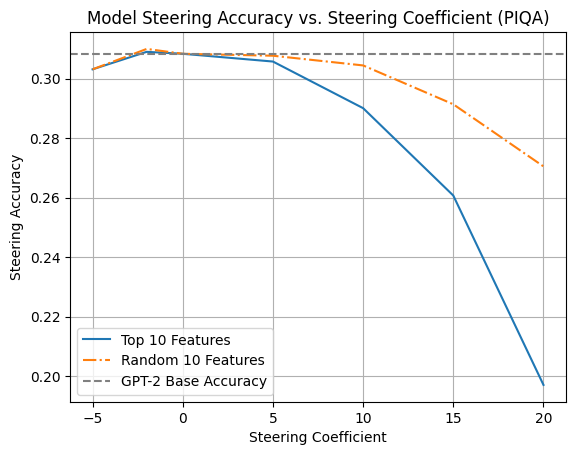

In [ ]:
# Plot Accuracy vs Steering Coefficient
l, u = normal_ci(piqa_results, num_prompts_to_analyse)
err = np.array([np.array(piqa_results) - l, u - np.array(piqa_results)])
plt.plot(mag_factors, piqa_results, linestyle='-', label=f'Top {k} Features')

l, u = normal_ci(piqa_control_results, num_prompts_to_analyse)
control_err = np.array([np.array(piqa_control_results) - l, u - np.array(piqa_control_results)])
plt.plot(mag_factors, piqa_control_results, linestyle='-.', label=f'Random {k} Features')

plt.axhline(y=piqa_gpt2_accuracy, color='gray', linestyle='--', label='GPT-2 Base Accuracy')

plt.xlabel('Steering Coefficient')
plt.ylabel('Steering Accuracy')
plt.title('Model Steering Accuracy vs. Steering Coefficient (PIQA)')
plt.grid(True)
plt.legend()
plt.show()